In [1]:
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, f1_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("./data/train.csv", encoding = 'ISO-8859-1', low_memory = False)
data.education = data.education.fillna('SCH')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   client_id         73799 non-null  int64 
 1   education         73799 non-null  object
 2   sex               73799 non-null  object
 3   age               73799 non-null  int64 
 4   car               73799 non-null  object
 5   car_type          73799 non-null  object
 6   decline_app_cnt   73799 non-null  int64 
 7   good_work         73799 non-null  int64 
 8   bki_request_cnt   73799 non-null  int64 
 9   home_address      73799 non-null  int64 
 10  work_address      73799 non-null  int64 
 11  income            73799 non-null  int64 
 12  foreign_passport  73799 non-null  object
 13  default           73799 non-null  int64 
dtypes: int64(9), object(5)
memory usage: 7.9+ MB


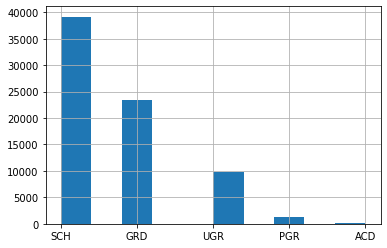

In [4]:
data.education.hist()

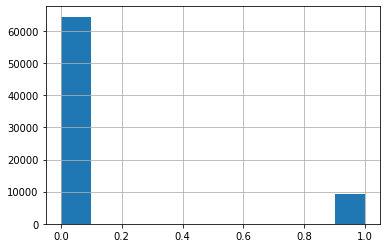

In [5]:
data.default.hist()

In [6]:
# бинарные
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
# катеригориальные
cat_cols = ['education', 'home_address', 'work_address']
# числовые
num_cols = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt']


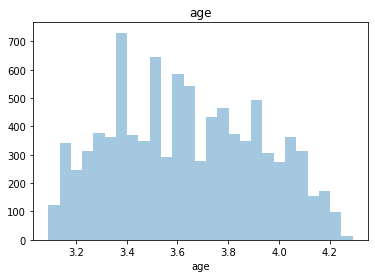

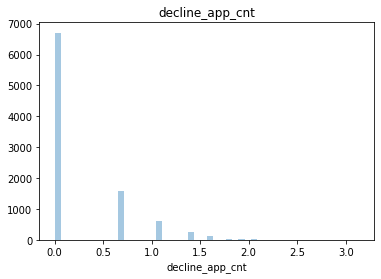

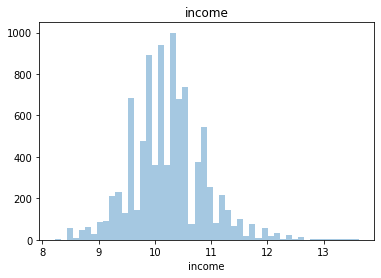

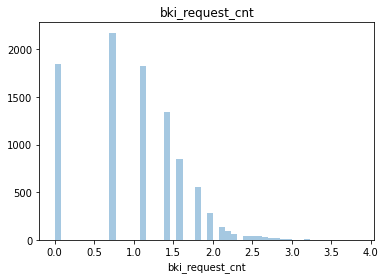

In [7]:
for i in num_cols:
    data[i] = np.log(data[i]+1)
    plt.figure()
    sns.distplot(data[i][data['default'] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

In [8]:
col = 'income'
print(data[col][data['default'] > 0].mean())
print(data[col][data['default'] == 0].mean())

10.247338977047855
10.360220850070698


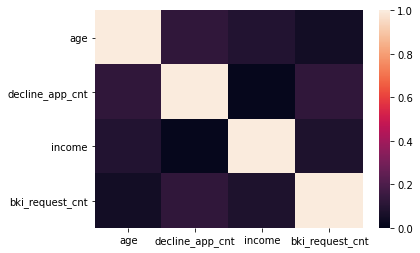

In [9]:
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1)

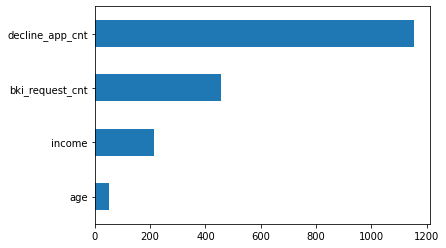

In [10]:
imp_num = Series(f_classif(data[num_cols], data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [11]:
label_encoder = LabelEncoder()

mapped_education = pd.Series(label_encoder.fit_transform(data['sex']))
print(dict(enumerate(label_encoder.classes_)))

{0: 'F', 1: 'M'}


In [12]:
mapped_education

0        1
1        0
2        1
3        0
4        1
        ..
73794    0
73795    1
73796    1
73797    0
73798    1
Length: 73799, dtype: int64

In [13]:
# Для бинарных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
    
# убедимся в преобразовании    
data.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
0,25905,SCH,1,4.143135,1,1,0.000000,0,0.693147,1,2,9.798183,0,0
1,63161,SCH,0,4.094345,0,0,0.000000,0,1.386294,2,3,9.852247,0,0
2,25887,SCH,1,3.258097,1,0,1.098612,0,0.693147,1,2,10.308986,1,0
3,16222,SCH,0,3.988984,0,0,0.000000,0,1.098612,2,3,9.210440,0,0
4,101655,GRD,1,3.891820,0,0,0.000000,1,0.693147,2,3,10.308986,1,0


In [14]:
dic_value_edu = {'SCH':1,'GRD':2, 'UGR':3, 'PGR':4, 'ACD':5}
data['education'] = data['education'].replace(to_replace=dic_value_edu)

In [15]:
# убедимся в преобразовании    
data.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
0,25905,1,1,4.143135,1,1,0.000000,0,0.693147,1,2,9.798183,0,0
1,63161,1,0,4.094345,0,0,0.000000,0,1.386294,2,3,9.852247,0,0
2,25887,1,1,3.258097,1,0,1.098612,0,0.693147,1,2,10.308986,1,0
3,16222,1,0,3.988984,0,0,0.000000,0,1.098612,2,3,9.210440,0,0
4,101655,2,1,3.891820,0,0,0.000000,1,0.693147,2,3,10.308986,1,0


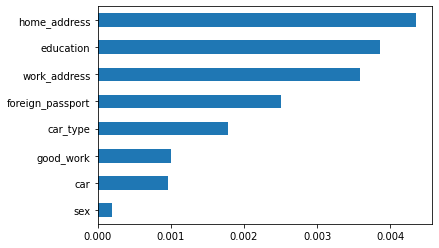

In [16]:
imp_cat = Series(mutual_info_classif(data[bin_cols + cat_cols], data['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [17]:
X_cat = OneHotEncoder(sparse = False).fit_transform(data[cat_cols].values)
len(X_cat[0])

11

In [18]:
# Стандартизация числовых переменных

X_num = StandardScaler().fit_transform(data[num_cols].values)

In [19]:
# Объединяем

X = np.hstack([X_num, data[bin_cols].values, X_cat])
Y = data['default'].values

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [21]:
logreg = LogisticRegression(class_weight='balanced', max_iter=1000)
logreg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [22]:
y_pred = logreg.predict(X_test)

In [23]:
f1_score(y_test, y_pred)

0.29324999999999996

In [24]:
confusion_matrix(y_test, y_pred)

array([[7933, 5000],
       [ 654, 1173]])

In [25]:
y_train_pred = logreg.predict(X_train)
confusion_matrix(y_train, y_train_pred)

array([[31514, 19980],
       [ 2799,  4746]])

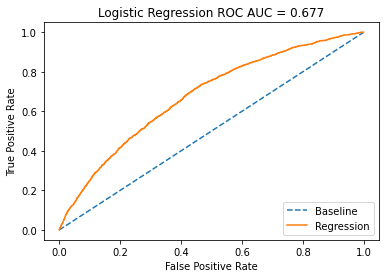

In [26]:
probs = logreg.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [32]:
from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression(class_weight='balanced' , max_iter=1000)
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 0.1


In [31]:
np.logspace(-1, 4, 100)

array([1.00000000e-01, 1.12332403e-01, 1.26185688e-01, 1.41747416e-01,
       1.59228279e-01, 1.78864953e-01, 2.00923300e-01, 2.25701972e-01,
       2.53536449e-01, 2.84803587e-01, 3.19926714e-01, 3.59381366e-01,
       4.03701726e-01, 4.53487851e-01, 5.09413801e-01, 5.72236766e-01,
       6.42807312e-01, 7.22080902e-01, 8.11130831e-01, 9.11162756e-01,
       1.02353102e+00, 1.14975700e+00, 1.29154967e+00, 1.45082878e+00,
       1.62975083e+00, 1.83073828e+00, 2.05651231e+00, 2.31012970e+00,
       2.59502421e+00, 2.91505306e+00, 3.27454916e+00, 3.67837977e+00,
       4.13201240e+00, 4.64158883e+00, 5.21400829e+00, 5.85702082e+00,
       6.57933225e+00, 7.39072203e+00, 8.30217568e+00, 9.32603347e+00,
       1.04761575e+01, 1.17681195e+01, 1.32194115e+01, 1.48496826e+01,
       1.66810054e+01, 1.87381742e+01, 2.10490414e+01, 2.36448941e+01,
       2.65608778e+01, 2.98364724e+01, 3.35160265e+01, 3.76493581e+01,
       4.22924287e+01, 4.75081016e+01, 5.33669923e+01, 5.99484250e+01,
      

In [29]:
y_pred

array([1, 1, 0, ..., 0, 1, 0])

In [33]:
f1_score(y_test, y_pred)

0.29324999999999996